In [ ]:
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cmocean.cm as cmo
import dask.array as da
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
import xarray as xr
import xesmf as xe

import jaxparrow as jpw
from jaxparrow.tools.geometry import compute_uv_grids
from jaxparrow.tools.kinematics import normalized_relative_vorticity
from jaxparrow.tools.operators import interpolation


jax.config.update("jax_enable_x64", True)

In [2]:
CM_TO_IN = 1 / 2.54
MAX_WIDTH = 17.5 * CM_TO_IN
MAX_HEIGHT = 20.5 * CM_TO_IN
DPI = 300

FONT_SIZE = 8

plt.rc("font", size=FONT_SIZE)
plt.rc("axes", titlesize=FONT_SIZE)
plt.rc("axes", labelsize=FONT_SIZE)
plt.rc("xtick", labelsize=FONT_SIZE)
plt.rc("ytick", labelsize=FONT_SIZE)
plt.rc("legend", fontsize=FONT_SIZE)

HW_SPACE = .33 * CM_TO_IN


def get_gridspec_kwargs(fig_width: float, fig_height: float) -> dict:
    return dict(wspace=HW_SPACE / fig_width, hspace=HW_SPACE / fig_height)


CLB_AXIS_HW = 1.25 * CM_TO_IN
CLB_BAR_HW = .33 * CM_TO_IN
CLB_HW_SPACE = .33 * CM_TO_IN


def get_clb_kwargs(axes_width: float, axes_height: float, clb_location: str, clb_shrink: float) -> dict:
    if clb_location in ("bottom", "top"):
        axes_hw_fraction = axes_height
        axes_hw_aspect = axes_width
    else:
        axes_hw_fraction = axes_width
        axes_hw_aspect = axes_height
    
    fraction = CLB_AXIS_HW / axes_hw_fraction
    aspect = clb_shrink * axes_hw_aspect / CLB_BAR_HW
    pad = CLB_HW_SPACE / axes_hw_fraction

    return dict(location=clb_location, fraction=fraction, shrink=clb_shrink, aspect=aspect, pad=pad)


TITLE_H = .5 * CM_TO_IN

PLOT_SWOT_HW_RATIO = (246-696) / (347-716)

In [ ]:
CYCLO_PAPER_DIRPATH = "/summer/meom/workdir/bertrava/cyclogeostrophy-paper"
FIGURES_PATH = f"{CYCLO_PAPER_DIRPATH}/figures"

In [4]:
ENATL60_VARS_PATH = "/summer/meom/MODEL_SET/eNATL60/eNATL60-BLB002/1d/eNATL60"
ENATL60_MASK_PATH = "/summer/meom/MODEL_SET/eNATL60/eNATL60-I/mask_eNATL60_3.6.nc"
SWOT_PATH = f"{CYCLO_PAPER_DIRPATH}/SWOT"
OUT_PATH = f"{CYCLO_PAPER_DIRPATH}/eNATL60-SWOT.zarr"

# Define pseudo-SWOT regridders

In [5]:
def fill_1d_linear_nearest(arr, interp_dim, nearest_dim):
    da = xr.DataArray(arr, dims=("y", "x"))

    filled = da.interpolate_na(dim=interp_dim, method="slinear", fill_value="extrapolate")
    filled = filled.interpolate_na(dim=nearest_dim, method="nearest")

    return filled.values


def preprocess_swot(swot_ds, descending_pass=False):
    swot_ds = swot_ds.rename({"latitude": "lat", "longitude": "lon"}).set_coords(["lat", "lon"])
    swot_ds["lon"] = ((swot_ds["lon"] + 180) % 360) - 180

    med_mask = (
        (swot_ds["lat"] > 30.0681) & (swot_ds["lat"] < 47.3764) & 
        (swot_ds["lon"] > -6.0326) & (swot_ds["lon"] < 42.355)
    )
    swot_ds = swot_ds.where(med_mask, drop=True)

    sea_mask = ~np.isnan(swot_ds["ssha_filtered"])
    min_lat, max_lat = swot_ds["lat"].where(sea_mask).min(), swot_ds["lat"].where(sea_mask).max()
    min_lon, max_lon = swot_ds["lon"].where(sea_mask).min(), swot_ds["lon"].where(sea_mask).max()
    swot_ds = swot_ds.where(
        (swot_ds["lat"] >= min_lat) & (swot_ds["lat"] <= max_lat) &
        (swot_ds["lon"] >= min_lon) & (swot_ds["lon"] <= max_lon),
        drop=True
    )

    if descending_pass:
        swot_ds = swot_ds.reindex(num_lines=swot_ds.num_lines[::-1], num_pixels=swot_ds.num_pixels[::-1])
        swot_ds = swot_ds.reindex(num_lines=swot_ds.num_lines[::-1], num_pixels=swot_ds.num_pixels[::-1])

    karin_mask = (np.abs(swot_ds.cross_track_distance) <= 60.0) & (np.abs(swot_ds.cross_track_distance) >= 10.0)
    swot_ds = swot_ds.where(karin_mask)

    return swot_ds, karin_mask


def open_enatl60_dataset(ds_path):
    enatl60_ds = xr.open_dataset(ds_path).isel(time_counter=0).drop_vars("time_counter")
    enatl60_ds = enatl60_ds.rename({"nav_lat": "lat", "nav_lon": "lon"}).set_coords(["lat", "lon"])
    return enatl60_ds


def get_swot_mask(enatl60_dss, swot_dss):
    swot_mask = False
    for enatl60_ds in enatl60_dss:
        for swot_ds in swot_dss:
            mask = ~(
                (enatl60_ds["lat"] < swot_ds["lat"].min()) | (enatl60_ds["lat"] > swot_ds["lat"].max()) |
                (enatl60_ds["lon"] < swot_ds["lon"].min()) | (enatl60_ds["lon"] > swot_ds["lon"].max())
            )
            swot_mask = swot_mask | mask
    return swot_mask


def preprocess_enatl60(enatl60_ds, enatl60_mask, swot_mask):
    enatl60_ds = enatl60_ds.where(swot_mask, drop=True)
    
    sea_mask = enatl60_mask.isel(t=0, z=0).where(swot_mask, drop=True)
    enatl60_ds = enatl60_ds.where(sea_mask, drop=True)

    invalid_mask = (enatl60_ds.lat == 0) & (enatl60_ds.lon == 0)
    lat = xr.where(invalid_mask, np.nan, enatl60_ds.lat)
    lon = xr.where(invalid_mask, np.nan, enatl60_ds.lon)

    valid_lat = fill_1d_linear_nearest(lat.values, interp_dim="x", nearest_dim="y")
    valid_lon = fill_1d_linear_nearest(lon.values, interp_dim="y", nearest_dim="x")

    enatl60_ds["lat"] = xr.where(invalid_mask, valid_lat, enatl60_ds.lat)
    enatl60_ds["lon"] = xr.where(invalid_mask, valid_lon, enatl60_ds.lon)
    
    return enatl60_ds


def get_regridder(enatl60_ds, swot_ds):
    regridder = xe.Regridder(enatl60_ds, swot_ds, "bilinear")
    return regridder


def regrid_enatl60_variable(enatl60_var_da, regridder):
    regridded_da = regridder(enatl60_var_da)
    return regridded_da

In [6]:
swot_003_ds = xr.open_dataset(f"{SWOT_PATH}/SWOT_L3_LR_SSH_Expert_003_v2.0.1.nc")
swot_003_ds, karin_003_mask = preprocess_swot(swot_003_ds)

swot_016_ds = xr.open_dataset(f"{SWOT_PATH}/SWOT_L3_LR_SSH_Expert_016_v2.0.1.nc")
swot_016_ds, karin_016_mask = preprocess_swot(swot_016_ds, descending_pass=True)

swot_datasets = [swot_003_ds, swot_016_ds]
karin_masks = [karin_003_mask, karin_016_mask]

In [7]:
enatl60_mask_ds = xr.open_dataset(ENATL60_MASK_PATH)
enatl60_t_ds = open_enatl60_dataset(f"{ENATL60_VARS_PATH}/eNATL60-BLB002_y2009m07d01.1d_SSH.nc")
enatl60_u_ds = open_enatl60_dataset(f"{ENATL60_VARS_PATH}/eNATL60-BLB002_y2009m07d01.1d_SSU.nc")
enatl60_v_ds = open_enatl60_dataset(f"{ENATL60_VARS_PATH}/eNATL60-BLB002_y2009m07d01.1d_SSV.nc")

In [8]:
swot_mask = get_swot_mask([enatl60_t_ds, enatl60_u_ds, enatl60_v_ds], swot_datasets)

In [15]:
enatl60_t_ds = preprocess_enatl60(enatl60_t_ds, enatl60_mask_ds.tmask, swot_mask)
enatl60_u_ds = preprocess_enatl60(enatl60_u_ds, enatl60_mask_ds.umask, swot_mask)
enatl60_v_ds = preprocess_enatl60(enatl60_v_ds, enatl60_mask_ds.vmask, swot_mask)

In [82]:
enatl60_lat_t = jnp.asarray(enatl60_t_ds.lat)
enatl60_lon_t = jnp.asarray(enatl60_t_ds.lon)

enatl60_lat_u, enatl60_lon_u, enatl60_lat_v, enatl60_lon_v = compute_uv_grids(enatl60_lat_t, enatl60_lon_t)

In [83]:
t_003_regridder = get_regridder(enatl60_t_ds, swot_003_ds)
u_003_regridder = get_regridder(enatl60_u_ds, swot_003_ds)
v_003_regridder = get_regridder(enatl60_v_ds, swot_003_ds)

t_016_regridder = get_regridder(enatl60_t_ds, swot_016_ds)
u_016_regridder = get_regridder(enatl60_u_ds, swot_016_ds)
v_016_regridder = get_regridder(enatl60_v_ds, swot_016_ds)

t_regridders = [t_003_regridder, t_016_regridder]
u_regridders = [u_003_regridder, u_016_regridder]
v_regridders = [v_003_regridder, v_016_regridder]

# Do the inversion for all eNATL60 time slices

In [ ]:
def attach_nrv(ds, u, v):
    ds["nrv"] = (
        ("y", "x"),
        np.asarray(normalized_relative_vorticity(
            jnp.asarray(u), jnp.asarray(v), enatl60_lat_u, enatl60_lon_u, enatl60_lat_v, enatl60_lon_v
        ))
    )
    return ds


def evaluation(
    u_da, v_da, nrv_da, 
    u_g, v_g, nrv_g, u_cg_var, v_cg_var, nrv_cg_var, u_cg_it, v_cg_it, nrv_cg_it
):
    u_ref = jnp.asarray(u_da.values)
    v_ref = jnp.asarray(v_da.values)
    nrv_ref = jnp.asarray(nrv_da.values)

    uv_err_g, uv_err_cg_var, uv_err_cg_it = map(
        lambda u, v: ((u - u_ref) ** 2 + (v - v_ref) ** 2) ** 0.5, 
        (u_g, u_cg_var, u_cg_it), (v_g, v_cg_var, v_cg_it)
    )

    nrv_err_g, nrv_err_cg_var, nrv_err_cg_it = map(
        lambda nrv_est: nrv_ref - nrv_est, (nrv_g, nrv_cg_var, nrv_cg_it)
    )

    return uv_err_g, uv_err_cg_var, uv_err_cg_it, nrv_err_g, nrv_err_cg_var, nrv_err_cg_it


def inversion(ssh_da, karin_mask):
    optim = optax.sgd(learning_rate=5e-3)
    optim = optax.chain(optax.clip(1), optim)

    ssh = jnp.asarray(ssh_da.values)
    lat_t = jnp.asarray(ssh_da.lat)
    lon_t = jnp.asarray(ssh_da.lon)

    u_cg_var, v_cg_var, u_g, v_g, lat_u, lon_u, lat_v, lon_v = jpw.cyclogeostrophy(
        ssh, lat_t, lon_t, optim=optim, return_geos=True, return_grids=True
    )
    u_cg_it, v_cg_it = jpw.cyclogeostrophy(ssh, lat_t, lon_t, method="iterative", return_geos=False, return_grids=False)

    nrv_g, nrv_cg_var, nrv_cg_it = map(
        lambda u, v: normalized_relative_vorticity(u, v, lat_u, lon_u, lat_v, lon_v), 
        (u_g, u_cg_var, u_cg_it), (v_g, v_cg_var, v_cg_it)
    )

    u_g, u_cg_var, u_cg_it = map(
        lambda arr: interpolation(arr, mask=~jnp.isfinite(arr), axis=1, padding="left"), (u_g, u_cg_var, u_cg_it)
    )
    v_g, v_cg_var, v_cg_it = map(
        lambda arr: interpolation(arr, mask=~jnp.isfinite(arr), axis=0, padding="left"), (v_g, v_cg_var, v_cg_it)
    )

    u_g, v_g, nrv_g, u_cg_var, v_cg_var, nrv_cg_var, u_cg_it, v_cg_it, nrv_cg_it = map(
        lambda arr: jnp.where(karin_mask.values.T, arr, jnp.nan), 
        (u_g, v_g, nrv_g, u_cg_var, v_cg_var, nrv_cg_var, u_cg_it, v_cg_it, nrv_cg_it)
    )

    return u_g, v_g, nrv_g, u_cg_var, v_cg_var, nrv_cg_var, u_cg_it, v_cg_it, nrv_cg_it


def arr_to_da(arr, lat, lon, name, units=None):
    attrs = {"long_name": name}
    if units is not None:
        attrs["units"] = units

    return xr.DataArray(
        arr[None, :, :].astype(np.float32),
        dims=("time", "y", "x"),
        attrs=attrs
    )


def inversion_and_evaluation(
    enatl60_t_block, enatl60_u_block, enatl60_v_block, 
    t_regridder, u_regridder, v_regridder,
    karin_mask
):
    ssh_da = regrid_enatl60_variable(enatl60_t_block.sossheig, t_regridder)
    u_da = regrid_enatl60_variable(enatl60_u_block.sozocrtx, u_regridder)
    v_da = regrid_enatl60_variable(enatl60_v_block.somecrty, v_regridder)
    nrv_da = regrid_enatl60_variable(enatl60_t_block.nrv, t_regridder)

    u_g, v_g, nrv_g, u_cg_var, v_cg_var, nrv_cg_var, u_cg_it, v_cg_it, nrv_cg_it = inversion(ssh_da, karin_mask)
    
    uv_err_g, uv_err_cg_var, uv_err_cg_it, nrv_err_g, nrv_err_cg_var, nrv_err_cg_it = evaluation(
        u_da, v_da, nrv_da, u_g, v_g, nrv_g, u_cg_var, v_cg_var, nrv_cg_var, u_cg_it, v_cg_it, nrv_cg_it
    )

    ds = xr.Dataset(
        {
            "u": arr_to_da(u_da.where(karin_mask).values, ssh_da.lat, ssh_da.lon, "Zonal velocity", "m/s"),
            "v": arr_to_da(v_da.where(karin_mask).values, ssh_da.lat, ssh_da.lon, "Meridional velocity", "m/s"),
            "nrv": arr_to_da(nrv_da.where(karin_mask).values, ssh_da.lat, ssh_da.lon, "Normalized relative vorticity"),
            "u_g": arr_to_da(u_g, ssh_da.lat, ssh_da.lon, "Zonal geostrophic velocity", "m/s"),
            "v_g": arr_to_da(v_g, ssh_da.lat, ssh_da.lon, "Meridional geostrophic velocity", "m/s"),
            "ucg_var": arr_to_da(u_cg_var, ssh_da.lat, ssh_da.lon, "Zonal cyclogeostrophic velocity (var)", "m/s"),
            "vcg_var": arr_to_da(v_cg_var, ssh_da.lat, ssh_da.lon, "Meridional cyclogeostrophic velocity (var)", "m/s"),
            "ucg_it": arr_to_da(u_cg_it, ssh_da.lat, ssh_da.lon, "Zonal cyclogeostrophic velocity (it)", "m/s"),
            "vcg_it": arr_to_da(v_cg_it, ssh_da.lat, ssh_da.lon, "Meridional cyclogeostrophic velocity (it)", "m/s"),
            "nrv_g": arr_to_da(nrv_g, ssh_da.lat, ssh_da.lon, "Normalized relative geostrophic vorticity"),
            "nrv_cg_var": arr_to_da(
                nrv_cg_var, ssh_da.lat, ssh_da.lon, "Normalized relative cyclogeostrophic vorticity (var)"
            ),
            "nrv_cg_it": arr_to_da(
                nrv_cg_it, ssh_da.lat, ssh_da.lon, "Normalized relative cyclogeostrophic vorticity (it)"
            ),
            "uv_err_g": arr_to_da(uv_err_g, ssh_da.lat, ssh_da.lon, "Geostrophic velocity error", "m/s"),
            "uv_err_cg_var": arr_to_da(
                uv_err_cg_var, ssh_da.lat, ssh_da.lon, "Cyclogeostrophic velocity error (var)", "m/s"
            ),
            "uv_err_cg_it": arr_to_da(
                uv_err_cg_it, ssh_da.lat, ssh_da.lon, "Cyclogeostrophic velocity error (it)", "m/s"
            ),
            "nrv_err_g": arr_to_da(
                nrv_err_g, ssh_da.lat, ssh_da.lon, "Normalized relative geostrophic vorticity error"
            ),
            "nrv_err_cg_var": arr_to_da(
                nrv_err_cg_var, ssh_da.lat, ssh_da.lon, "Normalized relative cyclogeostrophic vorticity error (var)"
            ),
            "nrv_err_cg_it": arr_to_da(
                nrv_err_cg_it, ssh_da.lat, ssh_da.lon, "Normalized relative cyclogeostrophic vorticity error (it)"
            ),
        }
    )

    return ds


def do_one_block(enatl60_t_block, enatl60_u_block, enatl60_v_block):
    enatl60_t_block = enatl60_t_block.isel(time=0)
    enatl60_u_block = enatl60_u_block.isel(time=0)
    enatl60_v_block = enatl60_v_block.isel(time=0)

    enatl60_t_block = preprocess_enatl60(enatl60_t_block, enatl60_mask_ds.tmask, swot_mask)
    enatl60_u_block = preprocess_enatl60(enatl60_u_block, enatl60_mask_ds.umask, swot_mask)
    enatl60_v_block = preprocess_enatl60(enatl60_v_block, enatl60_mask_ds.vmask, swot_mask)

    enatl60_t_block = attach_nrv(enatl60_t_block, enatl60_u_block.sozocrtx.values, enatl60_v_block.somecrty.values)

    result_datasets = []
    for karin_mask, t_regridder, u_regridder, v_regridder in zip(karin_masks, t_regridders, u_regridders, v_regridders):
        ds = inversion_and_evaluation(
            enatl60_t_block, enatl60_u_block, enatl60_v_block,
            t_regridder, u_regridder, v_regridder,
            karin_mask
        )

        result_datasets.append(ds)

    ds = xr.concat(result_datasets, dim="y")

    return ds

In [85]:
enatl60_t_ds = xr.open_mfdataset(f"{ENATL60_VARS_PATH}/*SSH.nc", combine="by_coords")
enatl60_u_ds = xr.open_mfdataset(f"{ENATL60_VARS_PATH}/*SSU.nc", combine="by_coords")
enatl60_v_ds = xr.open_mfdataset(f"{ENATL60_VARS_PATH}/*SSV.nc", combine="by_coords")

In [86]:
enatl60_t_ds = enatl60_t_ds.rename(
    {"time_counter": "time", "nav_lat": "lat", "nav_lon": "lon"}
).set_coords(["time", "lat", "lon"]).chunk({"time": 1, "y": -1, "x": -1})
enatl60_u_ds = enatl60_u_ds.rename(
    {"time_counter": "time", "nav_lat": "lat", "nav_lon": "lon"}
).set_coords(["time", "lat", "lon"]).chunk({"time": 1, "y": -1, "x": -1})
enatl60_v_ds = enatl60_v_ds.rename(
    {"time_counter": "time", "nav_lat": "lat", "nav_lon": "lon"}
).set_coords(["time", "lat", "lon"]).chunk({"time": 1, "y": -1, "x": -1})

In [87]:
enatl60_t_ds["lat"] = enatl60_t_ds["lat"].isel(time=0)
enatl60_t_ds["lon"] = enatl60_t_ds["lon"].isel(time=0)
enatl60_u_ds["lat"] = enatl60_u_ds["lat"].isel(time=0)
enatl60_u_ds["lon"] = enatl60_u_ds["lon"].isel(time=0)
enatl60_v_ds["lat"] = enatl60_v_ds["lat"].isel(time=0)
enatl60_v_ds["lon"] = enatl60_v_ds["lon"].isel(time=0)

In [ ]:
nt = enatl60_t_ds.time.size
ny = swot_003_ds.num_lines.size + swot_016_ds.num_lines.size
nx = swot_003_ds.num_pixels.size

empty_arr = da.empty((nt, ny, nx), chunks=(1, ny, nx), dtype=np.float32)
template = xr.Dataset(
    {
        "u": (("time", "y", "x"), empty_arr),
        "v": (("time", "y", "x"), empty_arr),
        "nrv": (("time", "y", "x"), empty_arr),
        "u_g": (("time", "y", "x"), empty_arr),
        "v_g": (("time", "y", "x"), empty_arr),
        "ucg_var": (("time", "y", "x"), empty_arr),
        "vcg_var": (("time", "y", "x"), empty_arr),
        "ucg_it": (("time", "y", "x"), empty_arr),
        "vcg_it": (("time", "y", "x"), empty_arr),
        "nrv_g": (("time", "y", "x"), empty_arr),
        "nrv_cg_var": (("time", "y", "x"), empty_arr),
        "nrv_cg_it": (("time", "y", "x"), empty_arr),
        "uv_err_g": (("time", "y", "x"), empty_arr),
        "uv_err_cg_var": (("time", "y", "x"), empty_arr),
        "uv_err_cg_it": (("time", "y", "x"), empty_arr),
        "nrv_err_g": (("time", "y", "x"), empty_arr),
        "nrv_err_cg_var": (("time", "y", "x"), empty_arr),
        "nrv_err_cg_it": (("time", "y", "x"), empty_arr),
    },
)

result = xr.map_blocks(do_one_block, enatl60_t_ds, args=(enatl60_u_ds, enatl60_v_ds), template=template)
result = result.assign_coords({
    "time": enatl60_t_ds.time.compute(),
    "lat": (("y", "x"), np.concat((swot_003_ds.lat, swot_016_ds.lat)).astype(np.float32)),
    "lon": (("y", "x"), np.concat((swot_003_ds.lon, swot_016_ds.lon)).astype(np.float32)),
})

result.to_zarr(OUT_PATH, compute=True, consolidated=False)

# Produce evaluation metrics and plots

In [9]:
result_ds = xr.open_zarr(OUT_PATH)
result_ds = result_ds.isel(time=slice(31, 62))  # average over one month (August)

/tmp/ipykernel_3384516/2325451477.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  result_ds = xr.open_zarr(OUT_PATH)


In [10]:
i_time = 14  # for snaptshots (15th of August)
time_i_str = np.datetime_as_string(result_ds.time.isel(time=i_time).values, unit="D")
y_i, m_i, d_i = time_i_str.split("-")

In [11]:
enatl60_t_snatshot_ds = open_enatl60_dataset(f"{ENATL60_VARS_PATH}/eNATL60-BLB002_y{y_i}m{m_i}d{d_i}.1d_SSH.nc")
enatl60_t_snatshot_ds = preprocess_enatl60(enatl60_t_ds, enatl60_mask_ds.tmask, swot_mask)

In [12]:
result_snatshot_ds = result_ds.isel(time=i_time)

In [13]:
(
    ((result_ds.uv_err_g ** 2).mean() ** 0.5).values.item(), 
    ((result_ds.uv_err_cg_var ** 2).mean() ** 0.5).values.item(), 
    ((result_ds.uv_err_cg_it ** 2).mean() ** 0.5).values.item()
), (
    ((result_ds.nrv_err_g ** 2).mean() ** 0.5).values.item(), 
    ((result_ds.nrv_err_cg_var ** 2).mean() ** 0.5).values.item(), 
    ((result_ds.nrv_err_cg_it ** 2).mean() ** 0.5).values.item()
)

((0.07004742324352264, 0.06705396622419357, 0.06752970814704895),
 (0.0679541602730751, 0.05937940627336502, 0.06827661395072937))

In [14]:
rmse_nrv_g = (result_ds.nrv_err_g ** 2).mean(dim="time") ** 0.5
rmse_nrv_cg_var = (result_ds.nrv_err_cg_var ** 2).mean(dim="time") ** 0.5
rmse_nrv_cg_it = (result_ds.nrv_err_cg_it ** 2).mean(dim="time") ** 0.5

rmse_nrv_diff_geo_var = (rmse_nrv_g - rmse_nrv_cg_var) / rmse_nrv_g * 100
rmse_nrv_diff_geo_it = (rmse_nrv_g - rmse_nrv_cg_it) / rmse_nrv_g * 100
rmse_nrv_diff_it_var = (rmse_nrv_cg_it - rmse_nrv_cg_var) / rmse_nrv_cg_it * 100

In [15]:
RMS_DIFF_REL_MAX = 100


def plot_diff(
    rmse_diff: xr.DataArray, latitude: xr.DataArray, longitude: xr.DataArray, title: str, label: str, ax: GeoAxes
):
    im = ax.pcolormesh(
        longitude, latitude, rmse_diff,
        cmap=cmo.balance_r, vmin=-RMS_DIFF_REL_MAX, vmax=RMS_DIFF_REL_MAX,
        transform=ccrs.PlateCarree()
    )
    ax.coastlines()

    ax.set_title(title, fontsize=FONT_SIZE)
    ax.set_title(label, loc="left", fontsize=FONT_SIZE)

    return im

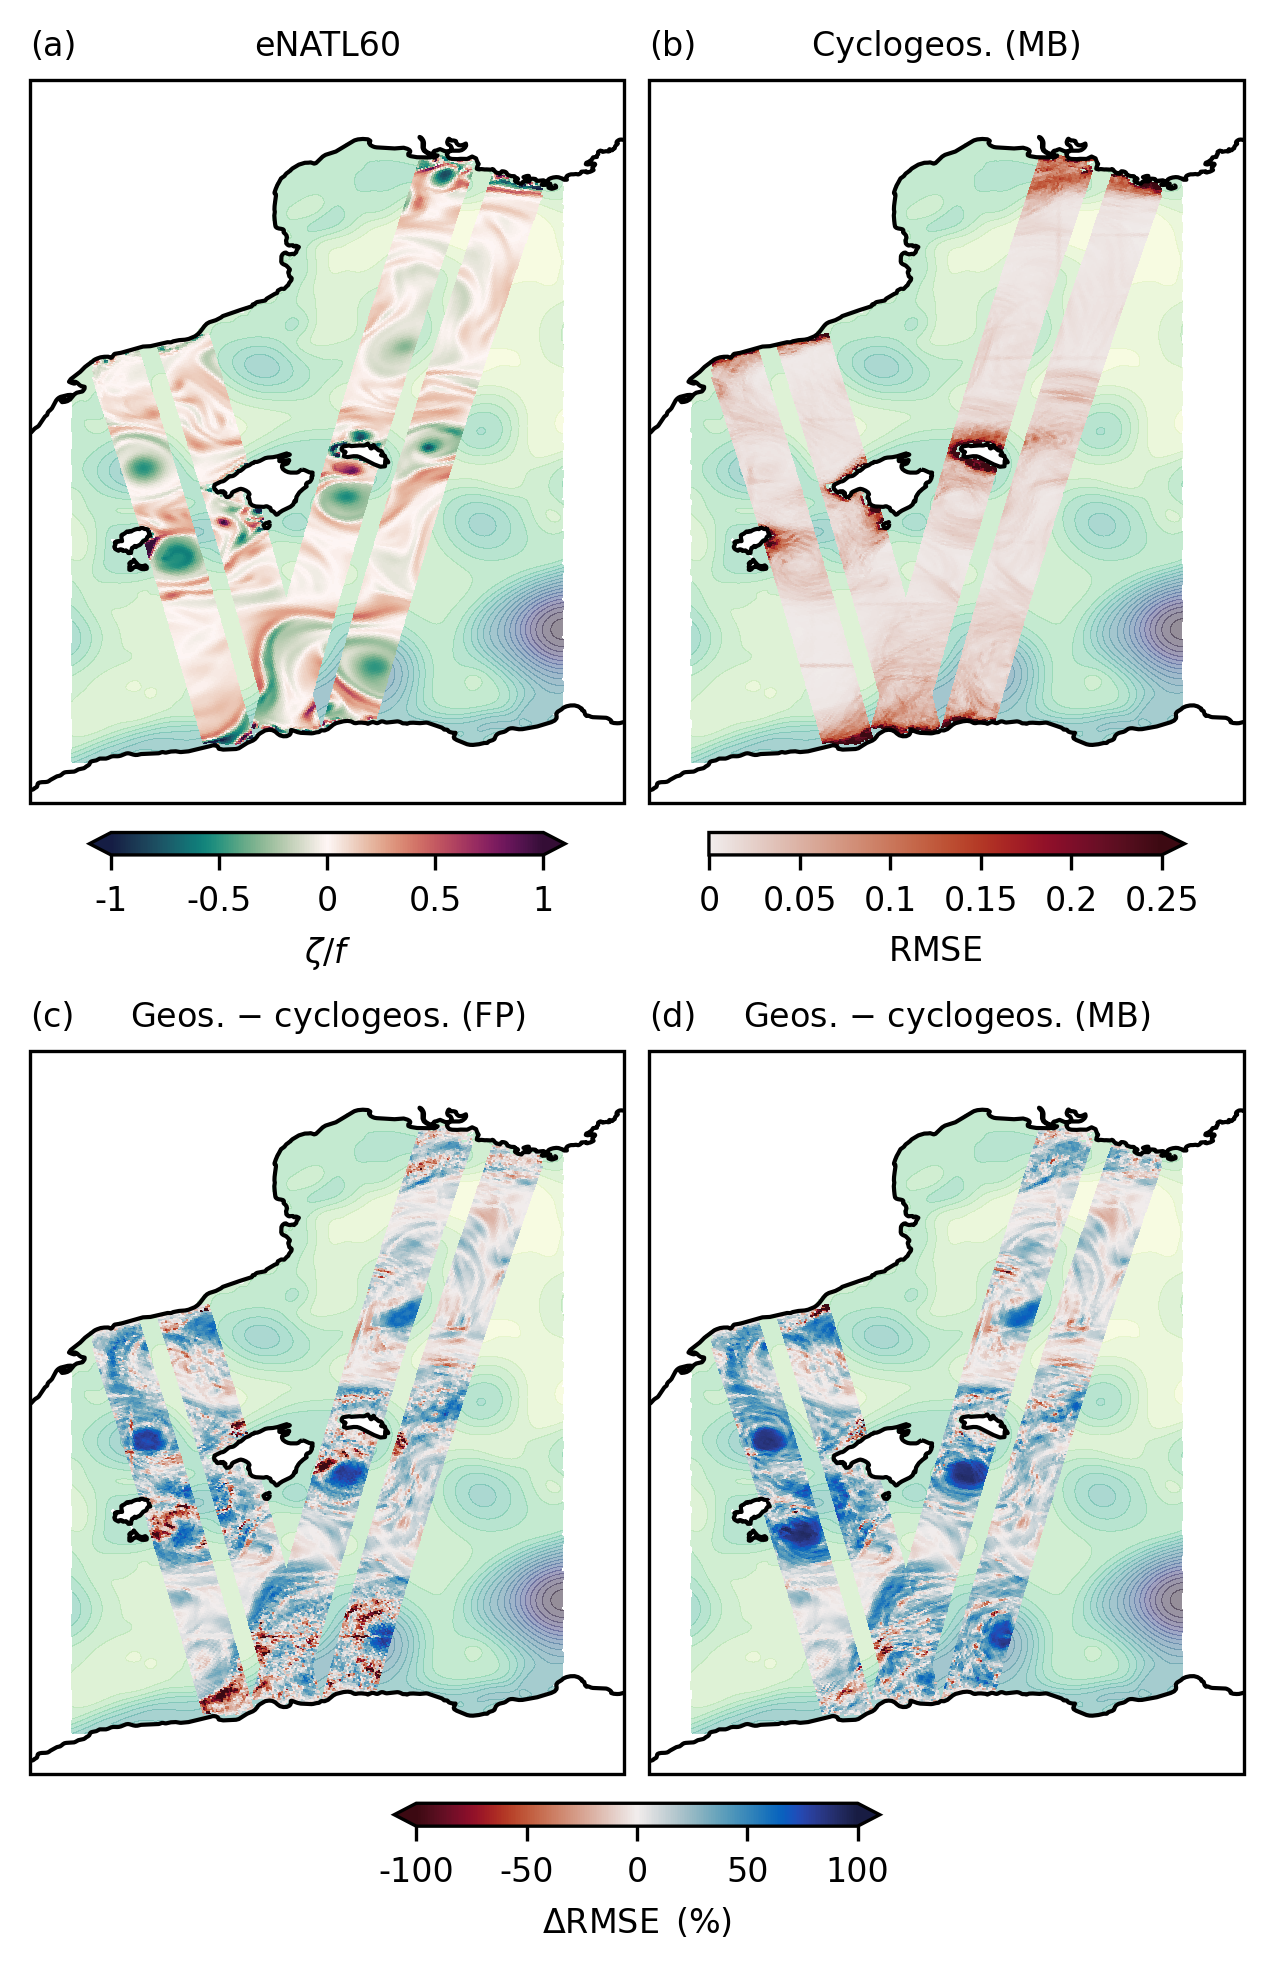

In [16]:
n_rows = 2
n_cols = 2
fig_width = MAX_WIDTH
fig_height = min(
    (
        ((fig_width - HW_SPACE * (n_cols - 1)) / n_cols * PLOT_SWOT_HW_RATIO + TITLE_H) * n_rows + 
        HW_SPACE * (n_rows - 1) + (CLB_AXIS_HW + CLB_HW_SPACE) * n_rows
    ),
    MAX_HEIGHT * .8
)

fig, axd = plt.subplot_mosaic(
    """
    AB
    CD
    """,
    subplot_kw=dict(projection=ccrs.PlateCarree()),
    gridspec_kw=get_gridspec_kwargs(fig_width, fig_height),
    figsize=(fig_width, fig_height), dpi=DPI, layout="compressed"
)

axd["A"].contourf(
    enatl60_t_snatshot_ds.lon, enatl60_t_snatshot_ds.lat, enatl60_t_snatshot_ds.sossheig,
    levels=20, cmap=cmo.deep, alpha=0.5
)
im_a = axd["A"].pcolormesh(
    result_snatshot_ds.lon, result_snatshot_ds.lat, result_snatshot_ds.nrv,
    cmap=cmo.curl, vmin=-1, vmax=1, transform=ccrs.PlateCarree()
)
axd["A"].coastlines()
axd["A"].set_title("eNATL60", fontsize=FONT_SIZE)
axd["A"].set_title("(a)", loc="left", fontsize=FONT_SIZE)

clb_a = fig.colorbar(
    im_a, ax=axd["A"], 
    **get_clb_kwargs(fig_width / 2, fig_height / 2, clb_location="bottom", clb_shrink=.8), 
    extend="both"
)
clb_a.set_label(label="$\\zeta/f$", size=FONT_SIZE)
tick_labels = [-1, -0.5, 0, 0.5, 1]
clb_a.set_ticks(tick_labels)
clb_a.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

axd["B"].contourf(
    enatl60_t_snatshot_ds.lon, enatl60_t_snatshot_ds.lat, enatl60_t_snatshot_ds.sossheig,
    levels=20, cmap=cmo.deep, alpha=0.5
)
im_b = axd["B"].pcolormesh(
    rmse_nrv_cg_var.lon, rmse_nrv_cg_var.lat, rmse_nrv_cg_var,
    cmap=cmo.amp, vmin=0, vmax=0.25, transform=ccrs.PlateCarree()
)
axd["B"].coastlines()
axd["B"].set_title("Cyclogeos. (MB)", fontsize=FONT_SIZE)
axd["B"].set_title("(b)", loc="left", fontsize=FONT_SIZE)

clb_b = fig.colorbar(
    im_b, ax=axd["B"],
    **get_clb_kwargs(fig_width / 2, fig_height / 2, clb_location="bottom", clb_shrink=.8), 
    extend="max"
)
clb_b.set_label(label="$\\operatorname{RMSE}$", size=FONT_SIZE)
tick_labels = [0, 0.05, 0.1, 0.15, 0.2, 0.25]
clb_b.set_ticks(tick_labels)
clb_b.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

axd["C"].contourf(
    enatl60_t_snatshot_ds.lon, enatl60_t_snatshot_ds.lat, enatl60_t_snatshot_ds.sossheig,
    levels=20, cmap=cmo.deep, alpha=0.5
)
im_c = plot_diff(
    rmse_nrv_diff_geo_it, rmse_nrv_diff_geo_it.lat, rmse_nrv_diff_geo_it.lon,
    "Geos. $-$ cyclogeos. (FP)",
    "(c)",
    axd["C"]
)

axd["D"].contourf(
    enatl60_t_snatshot_ds.lon, enatl60_t_snatshot_ds.lat, enatl60_t_snatshot_ds.sossheig,
    levels=20, cmap=cmo.deep, alpha=0.5
)
_ = plot_diff(
    rmse_nrv_diff_geo_var, rmse_nrv_diff_geo_var.lat, rmse_nrv_diff_geo_var.lon,
    "Geos. $-$ cyclogeos. (MB)",
    "(d)",
    axd["D"]
)

clb_cb = fig.colorbar(
    im_c, ax=list(axd.values())[2:],
    **get_clb_kwargs(fig_width, fig_height / 2, clb_location="bottom", clb_shrink=.4), 
    extend="both"
)
clb_cb.set_label(label="$\Delta\\operatorname{RMSE}$ (%)", size=FONT_SIZE)
tick_labels = [-100, -50, 0, 50, 100]
clb_cb.set_ticks(tick_labels)
clb_cb.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

plt.savefig(
    f"{FIGURES_PATH}/f04-revised.png", dpi=DPI, bbox_inches="tight"
)

plt.show()

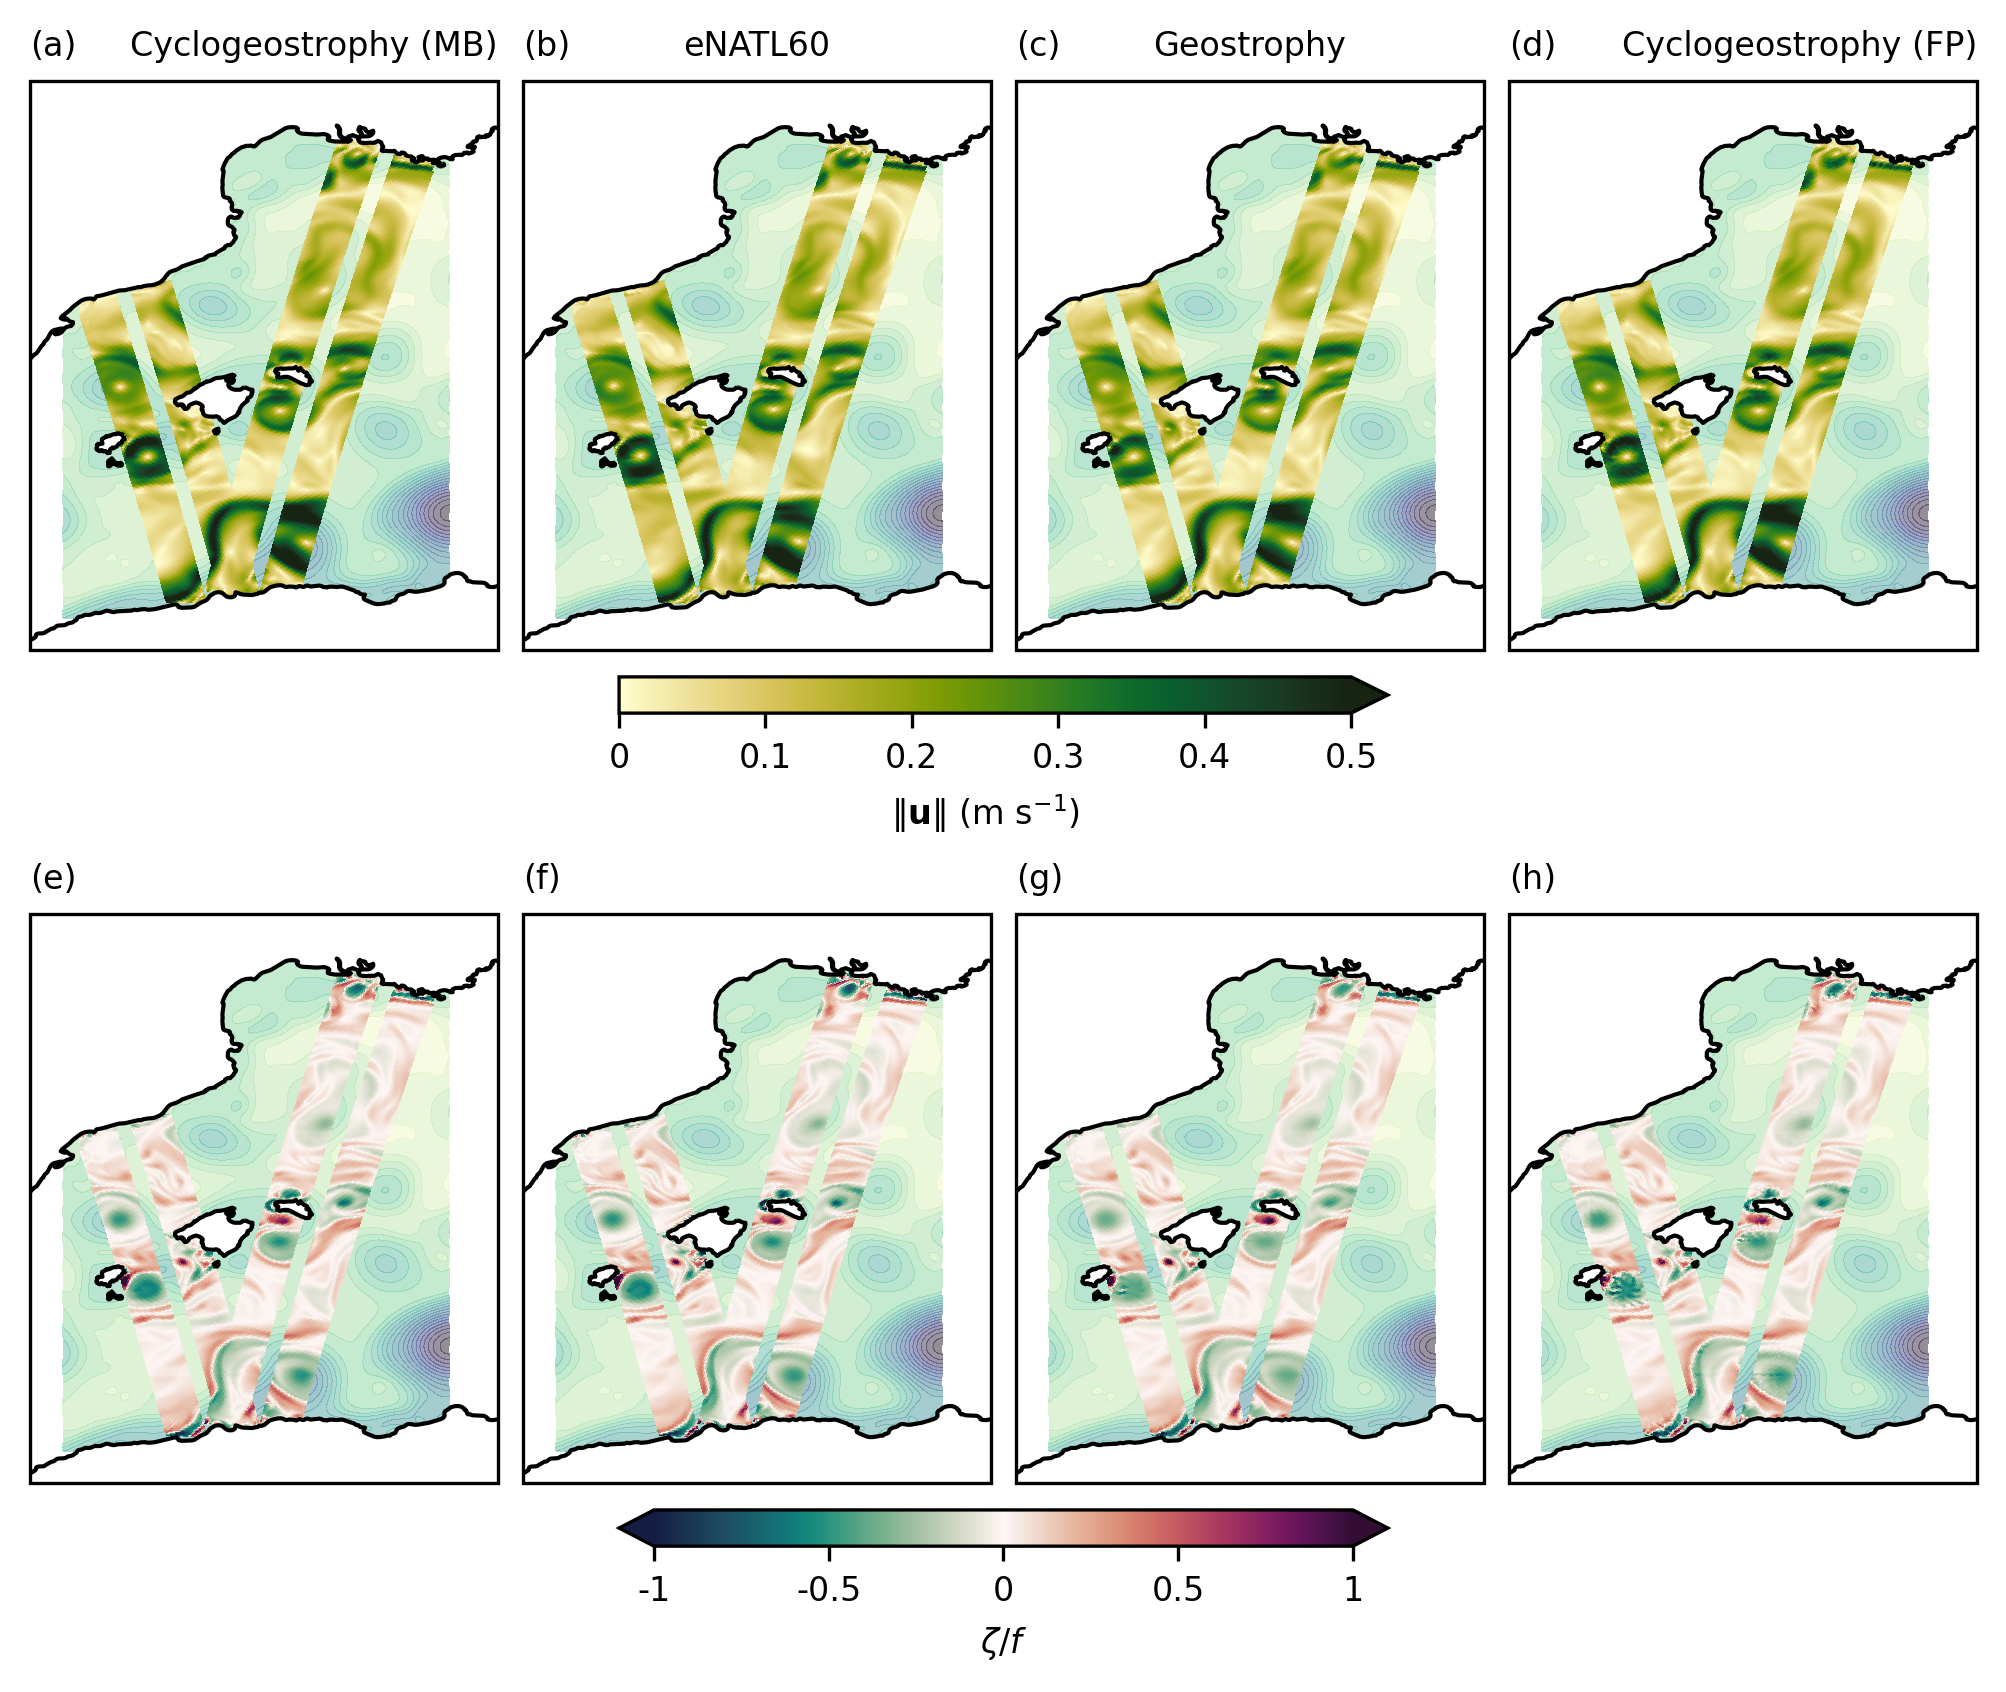

In [27]:
n_rows = 2
n_cols = 4
fig_width = MAX_WIDTH
fig_height = min(
    (
        ((fig_width - HW_SPACE * (n_cols - 1)) / n_cols * PLOT_SWOT_HW_RATIO) * n_rows + TITLE_H +
        HW_SPACE * (n_rows - 1) + (CLB_AXIS_HW + CLB_HW_SPACE) * n_rows
    ),
    MAX_HEIGHT * .9
)

fig, axd = plt.subplot_mosaic(
    """
    ABCD
    EFGH
    """,
    subplot_kw=dict(projection=ccrs.PlateCarree()),
    gridspec_kw=get_gridspec_kwargs(fig_width, fig_height),
    figsize=(fig_width, fig_height), dpi=DPI, layout="compressed"
)

axd["A"].contourf(
    enatl60_t_snatshot_ds.lon, enatl60_t_snatshot_ds.lat, enatl60_t_snatshot_ds.sossheig,
    levels=20, cmap=cmo.deep, alpha=0.5
)
axd["A"].pcolormesh(
    result_snatshot_ds.lon, result_snatshot_ds.lat, 
    (result_snatshot_ds.ucg_var ** 2 + result_snatshot_ds.vcg_var ** 2) ** 0.5,
    cmap=cmo.speed, vmin=0, vmax=0.5, transform=ccrs.PlateCarree()
)
axd["A"].coastlines()
axd["A"].set_title("Cyclogeostrophy (MB)", loc="right", fontsize=FONT_SIZE)
axd["A"].set_title("(a)", loc="left", fontsize=FONT_SIZE)

axd["B"].contourf(
    enatl60_t_snatshot_ds.lon, enatl60_t_snatshot_ds.lat, enatl60_t_snatshot_ds.sossheig,
    levels=20, cmap=cmo.deep, alpha=0.5
)
im_1 = axd["B"].pcolormesh(
    result_snatshot_ds.lon, result_snatshot_ds.lat, 
    (result_snatshot_ds.u ** 2 + result_snatshot_ds.v ** 2) ** 0.5,
    cmap=cmo.speed, vmin=0, vmax=0.5, transform=ccrs.PlateCarree()
)
axd["B"].coastlines()
axd["B"].set_title("eNATL60", fontsize=FONT_SIZE)
axd["B"].set_title("(b)", loc="left", fontsize=FONT_SIZE)

axd["C"].contourf(
    enatl60_t_snatshot_ds.lon, enatl60_t_snatshot_ds.lat, enatl60_t_snatshot_ds.sossheig,
    levels=20, cmap=cmo.deep, alpha=0.5
)
axd["C"].pcolormesh(
    result_snatshot_ds.lon, result_snatshot_ds.lat, 
    (result_snatshot_ds.u_g ** 2 + result_snatshot_ds.v_g ** 2) ** 0.5,
    cmap=cmo.speed, vmin=0, vmax=0.5, transform=ccrs.PlateCarree()
)
axd["C"].coastlines()
axd["C"].set_title("Geostrophy", fontsize=FONT_SIZE)
axd["C"].set_title("(c)", loc="left", fontsize=FONT_SIZE)

axd["D"].contourf(
    enatl60_t_snatshot_ds.lon, enatl60_t_snatshot_ds.lat, enatl60_t_snatshot_ds.sossheig,
    levels=20, cmap=cmo.deep, alpha=0.5
)
axd["D"].pcolormesh(
    result_snatshot_ds.lon, result_snatshot_ds.lat, 
    (result_snatshot_ds.ucg_it ** 2 + result_snatshot_ds.vcg_it ** 2) ** 0.5,
    cmap=cmo.speed, vmin=0, vmax=0.5, transform=ccrs.PlateCarree()
)
axd["D"].coastlines()
axd["D"].set_title("Cyclogeostrophy (FP)", loc="right", fontsize=FONT_SIZE)
axd["D"].set_title("(d)", loc="left", fontsize=FONT_SIZE)

clb_1 = fig.colorbar(
    im_1, ax=[axd["B"], axd["C"]],
    **get_clb_kwargs(fig_width / 2, fig_height / 2, clb_location="bottom", clb_shrink=0.8), 
    extend="max"
)
clb_1.set_label(label="$\| \\mathbf{u} \|$ (m s$^{-1}$)", size=FONT_SIZE)
tick_labels = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
clb_1.set_ticks(tick_labels)
clb_1.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

axd["E"].contourf(
    enatl60_t_snatshot_ds.lon, enatl60_t_snatshot_ds.lat, enatl60_t_snatshot_ds.sossheig,
    levels=20, cmap=cmo.deep, alpha=0.5
)
axd["E"].pcolormesh(
    result_snatshot_ds.lon, result_snatshot_ds.lat, result_snatshot_ds.nrv_cg_var,
    cmap=cmo.curl, vmin=-1, vmax=1, transform=ccrs.PlateCarree()
)
axd["E"].coastlines()
axd["E"].set_title("(e)", loc="left", fontsize=FONT_SIZE)

axd["F"].contourf(
    enatl60_t_snatshot_ds.lon, enatl60_t_snatshot_ds.lat, enatl60_t_snatshot_ds.sossheig,
    levels=20, cmap=cmo.deep, alpha=0.5
)
im_2 = axd["F"].pcolormesh(
    result_snatshot_ds.lon, result_snatshot_ds.lat, result_snatshot_ds.nrv,
    cmap=cmo.curl, vmin=-1, vmax=1, transform=ccrs.PlateCarree()
)
axd["F"].coastlines()
axd["F"].set_title("(f)", loc="left", fontsize=FONT_SIZE)

axd["G"].contourf(
    enatl60_t_snatshot_ds.lon, enatl60_t_snatshot_ds.lat, enatl60_t_snatshot_ds.sossheig,
    levels=20, cmap=cmo.deep, alpha=0.5
)
axd["G"].pcolormesh(
    result_snatshot_ds.lon, result_snatshot_ds.lat, result_snatshot_ds.nrv_g,
    cmap=cmo.curl, vmin=-1, vmax=1, transform=ccrs.PlateCarree()
)
axd["G"].coastlines()
axd["G"].set_title("(g)", loc="left", fontsize=FONT_SIZE)

axd["H"].contourf(
    enatl60_t_snatshot_ds.lon, enatl60_t_snatshot_ds.lat, enatl60_t_snatshot_ds.sossheig,
    levels=20, cmap=cmo.deep, alpha=0.5
)
axd["H"].pcolormesh(
    result_snatshot_ds.lon, result_snatshot_ds.lat, result_snatshot_ds.nrv_cg_it,
    cmap=cmo.curl, vmin=-1, vmax=1, transform=ccrs.PlateCarree()
)
axd["H"].coastlines()
axd["H"].set_title("(h)", loc="left", fontsize=FONT_SIZE)

clb_2 = fig.colorbar(
    im_2, ax=[axd["F"], axd["G"]],
    **get_clb_kwargs(fig_width / 2, fig_height / 2, clb_location="bottom", clb_shrink=0.8), 
    extend="both"
)
clb_2.set_label(label="$\\zeta/f$", size=FONT_SIZE)
tick_labels = [-1, -0.5, 0, 0.5, 1]
clb_2.set_ticks(tick_labels)
clb_2.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

plt.savefig(
    f"{FIGURES_PATH}/fA01-revised.png", dpi=DPI, bbox_inches="tight"
)

plt.show()

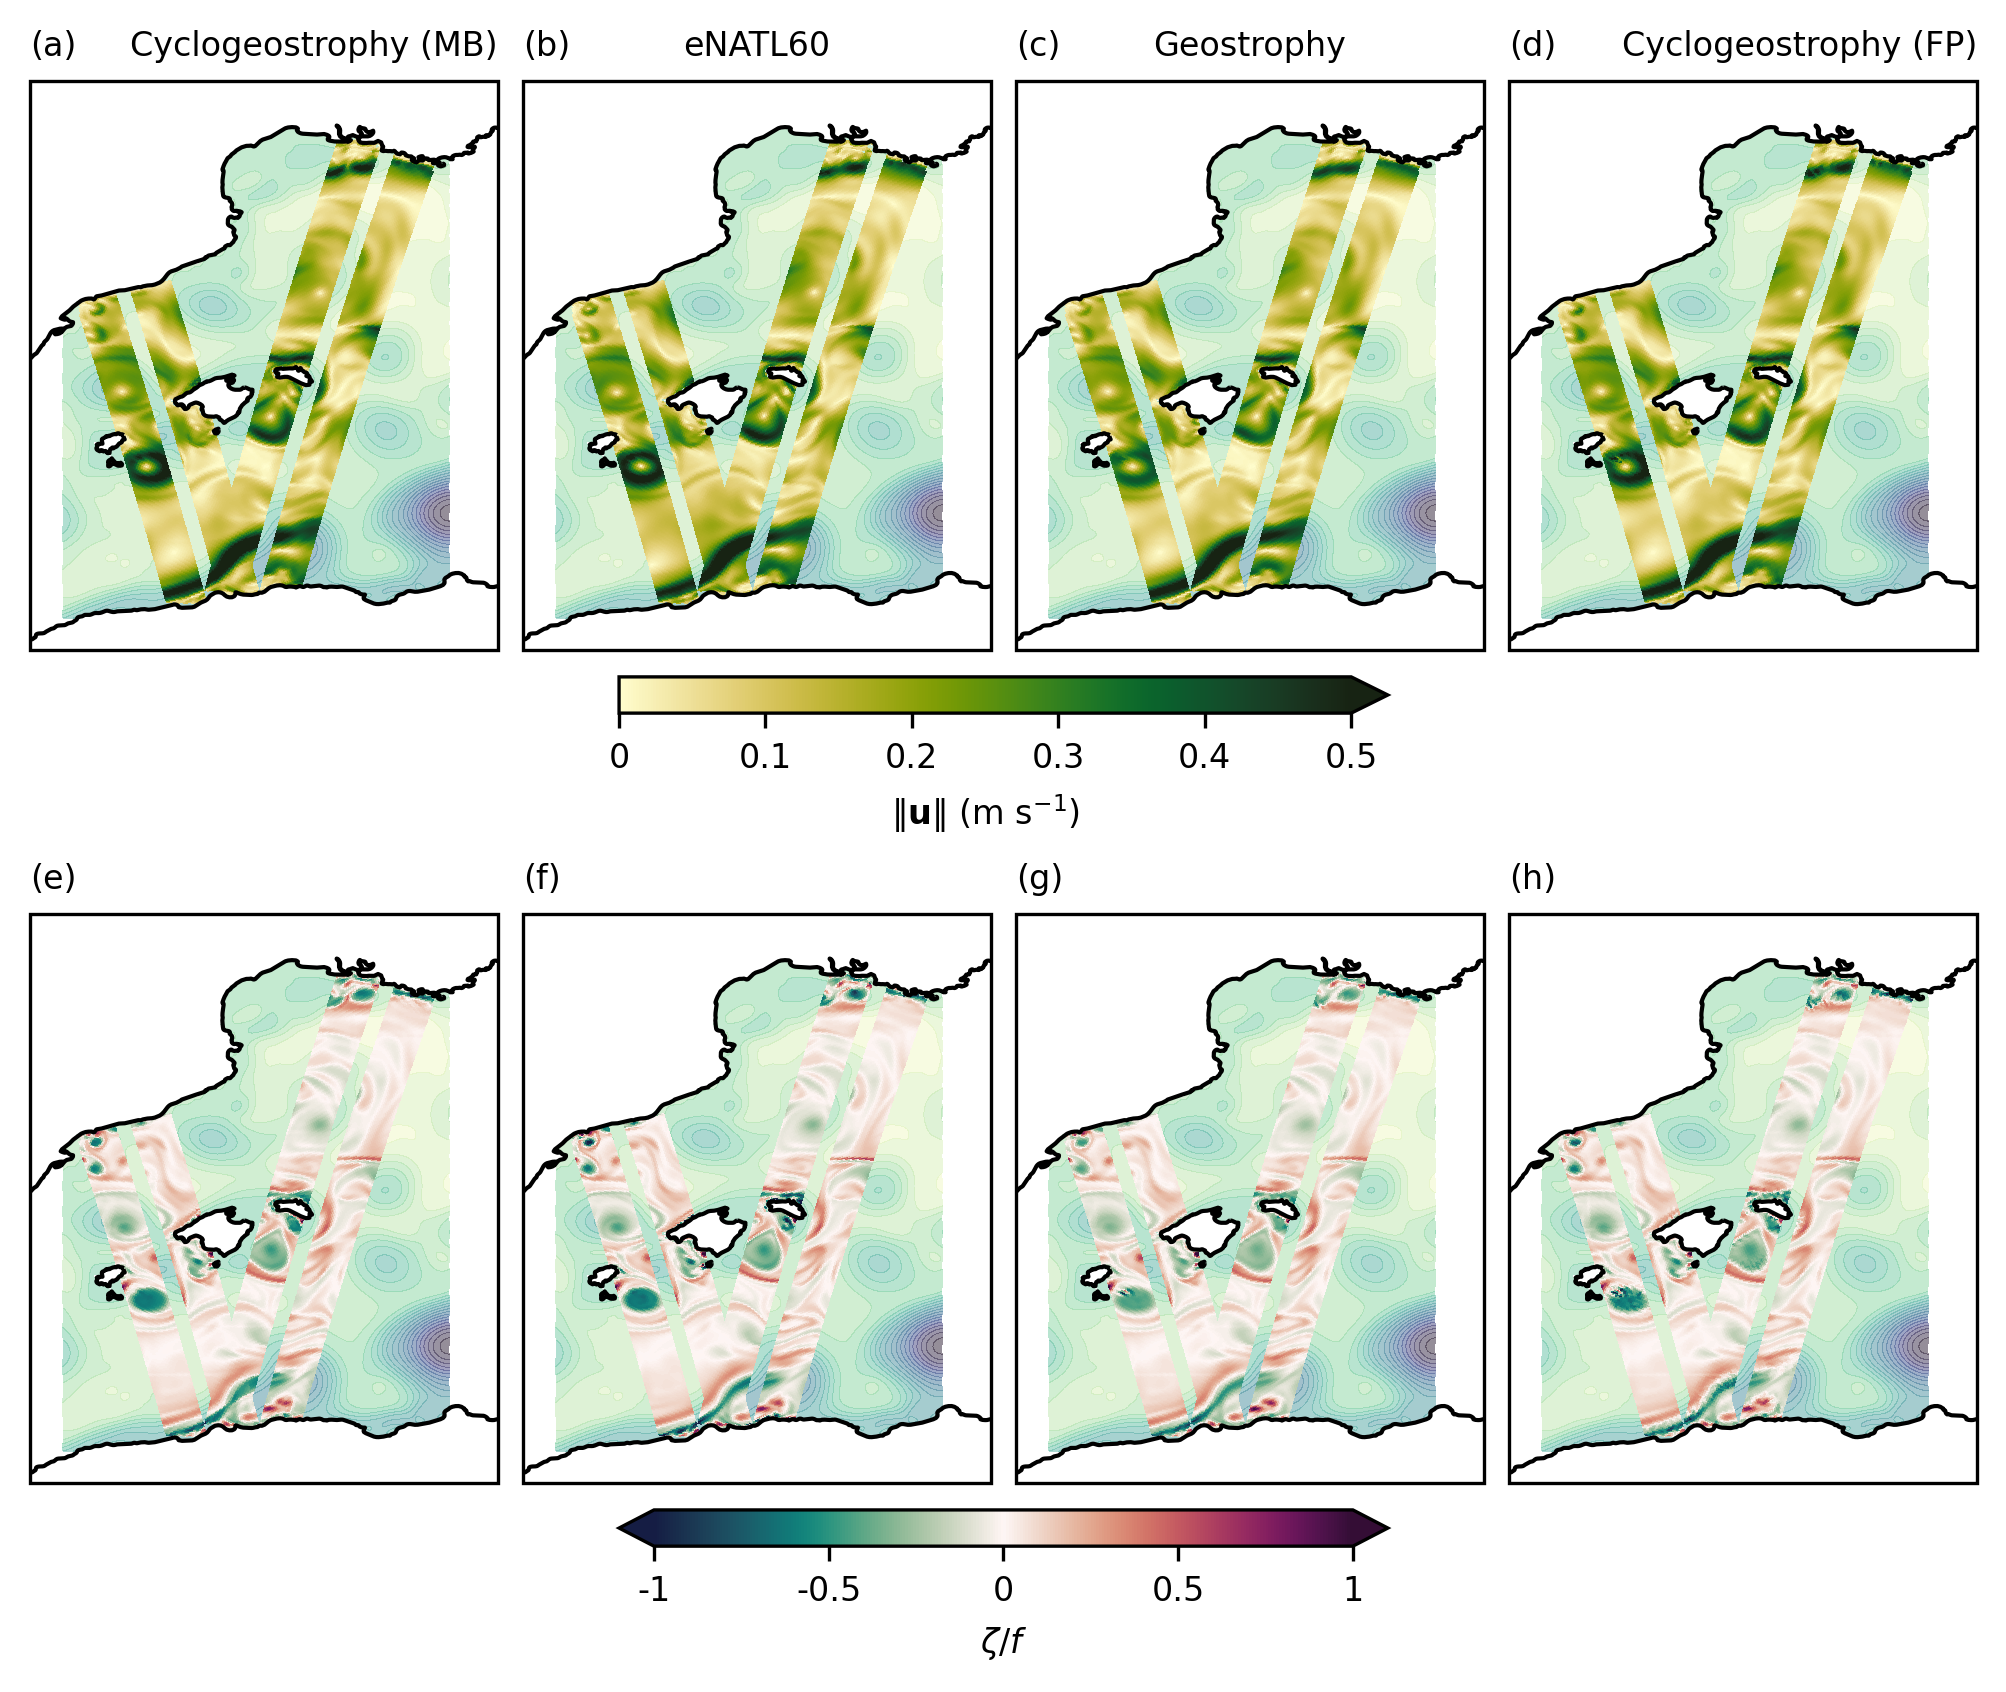

In [18]:
result_snatshot_ds = result_ds.isel(time=-1)

n_rows = 2
n_cols = 4
fig_width = MAX_WIDTH
fig_height = min(
    (
        ((fig_width - HW_SPACE * (n_cols - 1)) / n_cols * PLOT_SWOT_HW_RATIO) * n_rows + TITLE_H +
        HW_SPACE * (n_rows - 1) + (CLB_AXIS_HW + CLB_HW_SPACE) * n_rows
    ),
    MAX_HEIGHT * .9
)

fig, axd = plt.subplot_mosaic(
    """
    ABCD
    EFGH
    """,
    subplot_kw=dict(projection=ccrs.PlateCarree()),
    gridspec_kw=get_gridspec_kwargs(fig_width, fig_height),
    figsize=(fig_width, fig_height), dpi=DPI, layout="compressed"
)

axd["A"].contourf(
    enatl60_t_snatshot_ds.lon, enatl60_t_snatshot_ds.lat, enatl60_t_snatshot_ds.sossheig,
    levels=20, cmap=cmo.deep, alpha=0.5
)
axd["A"].pcolormesh(
    result_snatshot_ds.lon, result_snatshot_ds.lat, 
    (result_snatshot_ds.ucg_var ** 2 + result_snatshot_ds.vcg_var ** 2) ** 0.5,
    cmap=cmo.speed, vmin=0, vmax=0.5, transform=ccrs.PlateCarree()
)
axd["A"].coastlines()
axd["A"].set_title("Cyclogeostrophy (MB)", loc="right", fontsize=FONT_SIZE)
axd["A"].set_title("(a)", loc="left", fontsize=FONT_SIZE)

axd["B"].contourf(
    enatl60_t_snatshot_ds.lon, enatl60_t_snatshot_ds.lat, enatl60_t_snatshot_ds.sossheig,
    levels=20, cmap=cmo.deep, alpha=0.5
)
im_1 = axd["B"].pcolormesh(
    result_snatshot_ds.lon, result_snatshot_ds.lat, 
    (result_snatshot_ds.u ** 2 + result_snatshot_ds.v ** 2) ** 0.5,
    cmap=cmo.speed, vmin=0, vmax=0.5, transform=ccrs.PlateCarree()
)
axd["B"].coastlines()
axd["B"].set_title("eNATL60", fontsize=FONT_SIZE)
axd["B"].set_title("(b)", loc="left", fontsize=FONT_SIZE)

axd["C"].contourf(
    enatl60_t_snatshot_ds.lon, enatl60_t_snatshot_ds.lat, enatl60_t_snatshot_ds.sossheig,
    levels=20, cmap=cmo.deep, alpha=0.5
)
axd["C"].pcolormesh(
    result_snatshot_ds.lon, result_snatshot_ds.lat, 
    (result_snatshot_ds.u_g ** 2 + result_snatshot_ds.v_g ** 2) ** 0.5,
    cmap=cmo.speed, vmin=0, vmax=0.5, transform=ccrs.PlateCarree()
)
axd["C"].coastlines()
axd["C"].set_title("Geostrophy", fontsize=FONT_SIZE)
axd["C"].set_title("(c)", loc="left", fontsize=FONT_SIZE)

axd["D"].contourf(
    enatl60_t_snatshot_ds.lon, enatl60_t_snatshot_ds.lat, enatl60_t_snatshot_ds.sossheig,
    levels=20, cmap=cmo.deep, alpha=0.5
)
axd["D"].pcolormesh(
    result_snatshot_ds.lon, result_snatshot_ds.lat, 
    (result_snatshot_ds.ucg_it ** 2 + result_snatshot_ds.vcg_it ** 2) ** 0.5,
    cmap=cmo.speed, vmin=0, vmax=0.5, transform=ccrs.PlateCarree()
)
axd["D"].coastlines()
axd["D"].set_title("Cyclogeostrophy (FP)", loc="right", fontsize=FONT_SIZE)
axd["D"].set_title("(d)", loc="left", fontsize=FONT_SIZE)

clb_1 = fig.colorbar(
    im_1, ax=[axd["B"], axd["C"]],
    **get_clb_kwargs(fig_width / 2, fig_height / 2, clb_location="bottom", clb_shrink=0.8), 
    extend="max"
)
clb_1.set_label(label="$\| \\mathbf{u} \|$ (m s$^{-1}$)", size=FONT_SIZE)
tick_labels = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
clb_1.set_ticks(tick_labels)
clb_1.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

axd["E"].contourf(
    enatl60_t_snatshot_ds.lon, enatl60_t_snatshot_ds.lat, enatl60_t_snatshot_ds.sossheig,
    levels=20, cmap=cmo.deep, alpha=0.5
)
axd["E"].pcolormesh(
    result_snatshot_ds.lon, result_snatshot_ds.lat, result_snatshot_ds.nrv_cg_var,
    cmap=cmo.curl, vmin=-1, vmax=1, transform=ccrs.PlateCarree()
)
axd["E"].coastlines()
axd["E"].set_title("(e)", loc="left", fontsize=FONT_SIZE)

axd["F"].contourf(
    enatl60_t_snatshot_ds.lon, enatl60_t_snatshot_ds.lat, enatl60_t_snatshot_ds.sossheig,
    levels=20, cmap=cmo.deep, alpha=0.5
)
im_2 = axd["F"].pcolormesh(
    result_snatshot_ds.lon, result_snatshot_ds.lat, result_snatshot_ds.nrv,
    cmap=cmo.curl, vmin=-1, vmax=1, transform=ccrs.PlateCarree()
)
axd["F"].coastlines()
axd["F"].set_title("(f)", loc="left", fontsize=FONT_SIZE)

axd["G"].contourf(
    enatl60_t_snatshot_ds.lon, enatl60_t_snatshot_ds.lat, enatl60_t_snatshot_ds.sossheig,
    levels=20, cmap=cmo.deep, alpha=0.5
)
axd["G"].pcolormesh(
    result_snatshot_ds.lon, result_snatshot_ds.lat, result_snatshot_ds.nrv_g,
    cmap=cmo.curl, vmin=-1, vmax=1, transform=ccrs.PlateCarree()
)
axd["G"].coastlines()
axd["G"].set_title("(g)", loc="left", fontsize=FONT_SIZE)

axd["H"].contourf(
    enatl60_t_snatshot_ds.lon, enatl60_t_snatshot_ds.lat, enatl60_t_snatshot_ds.sossheig,
    levels=20, cmap=cmo.deep, alpha=0.5
)
axd["H"].pcolormesh(
    result_snatshot_ds.lon, result_snatshot_ds.lat, result_snatshot_ds.nrv_cg_it,
    cmap=cmo.curl, vmin=-1, vmax=1, transform=ccrs.PlateCarree()
)
axd["H"].coastlines()
axd["H"].set_title("(h)", loc="left", fontsize=FONT_SIZE)

clb_2 = fig.colorbar(
    im_2, ax=[axd["F"], axd["G"]],
    **get_clb_kwargs(fig_width / 2, fig_height / 2, clb_location="bottom", clb_shrink=0.8), 
    extend="both"
)
clb_2.set_label(label="$\\zeta/f$", size=FONT_SIZE)
tick_labels = [-1, -0.5, 0, 0.5, 1]
clb_2.set_ticks(tick_labels)
clb_2.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

# plt.savefig(
#     f"{FIGURES_PATH}/fA01-revised.png", dpi=DPI, bbox_inches="tight"
# )

plt.show()